In [1]:
from CookieTTS._2_ttm.flowtts.model import FlowTTS
from CookieTTS._2_ttm.flowtts.model import load_model
from CookieTTS._2_ttm.flowtts.hparams import create_hparams
from CookieTTS.utils.audio.stft import TacotronSTFT, STFT
from CookieTTS.utils.text import text_to_sequence

import sys
sys.path.append('../_4_mtw/waveglow') # add WaveGlow to System path for easier importing
import numpy as np
import torch

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
def plot_data(data, title=None, figsize=(20, 3.5)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        if title:
            axes[i].set_title(title[i])
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [3]:
hparams = create_hparams()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Speaker ID = tensor([5], device='cuda:0')
G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\checkpoint_3000
On iter 3000
torch.Size([1, 108, 18])
Text: `Flow. Tee Tee Ess.` [mean -5.834400] [max -2.475498] [min -8.298990]
torch.Size([1, 69, 11])
Text: `Sssssssssss`        [mean -5.332178] [max -2.087299] [min -7.953905]
torch.Size([1, 340, 90])
Text: `It's been a long time since I've been able to make a Google account without a phone number` [mean -5.384195] [max -1.783894] [min -7.947422]
G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\checkpoint_8000
On iter 8000
torch.Size([1, 111, 18])
Text: `Flow. Tee Tee Ess.` [mean -5.286706] [max -1.569942] [min -8.013769]
torch.Size([1, 67, 11])
Text: `Sssssssssss`        [mean -4.977195] [max -1.468405] [min -7.797884]
torch.Size([1, 314, 90])
Text: `It's been a long time since I've been able to make a Google account without a phone number` [mean -5.031109] [max -1.368746] [min -7.769335]
G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\fl

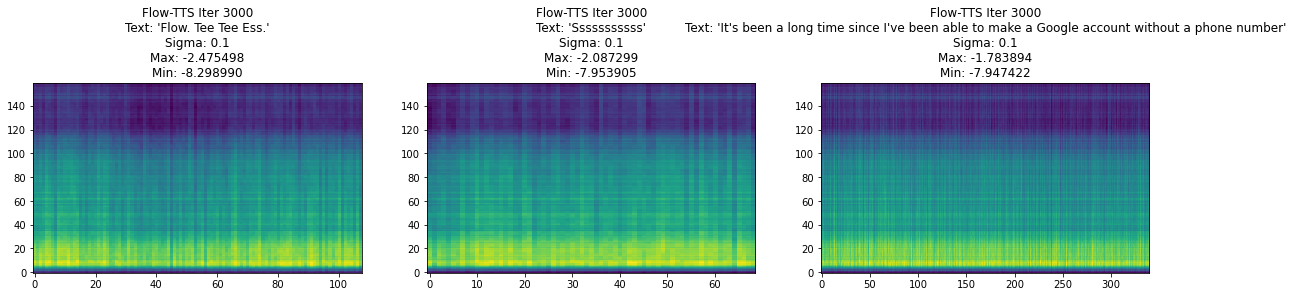

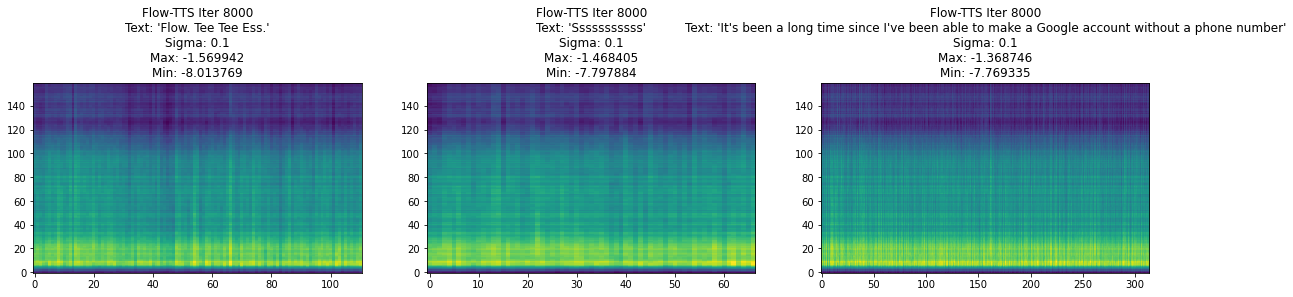

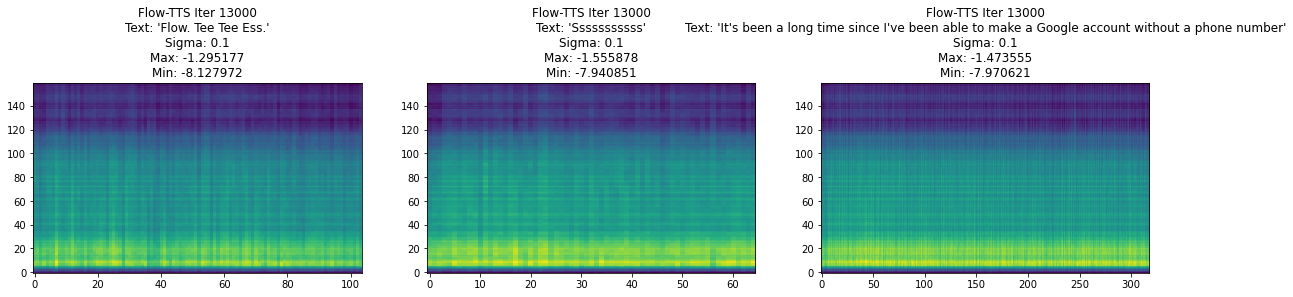

In [10]:
checkpoint_paths = [
    r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\checkpoint_3000",
    r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\checkpoint_8000",
    r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\checkpoint_13000",
]

texts = [
    "Flow. Tee Tee Ess.",
    "Sssssssssss",
    "It's been a long time since I've been able to make a Google account without a phone number",
]

sigma = [0.1,]

# Speaker IDs
speaker_ids = torch.LongTensor([5,]).cuda()
print('Speaker ID =', speaker_ids)
# Generate
with torch.no_grad():
    for sigma_ in sigma:
        for i, checkpoint_path in enumerate(checkpoint_paths):
            print(checkpoint_path)
            checkpoint = torch.load(checkpoint_path)
            iteration = checkpoint['iteration']
            print(f"On iter {iteration}")
            model = load_model(hparams)
            model.load_state_dict(checkpoint['state_dict'])
            _ = model.cuda().eval()
            mel_outputs = []
            alignments = []
            titles=[]
            for text in texts:
                sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
                sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
                mel_output, alignment, *_ = model.inference(sequence, speaker_ids, sigma=sigma_)
                mel_output = (mel_output-3.5)*8 # inverse transform magnitudes from -1 -> 1 to -11.5 -> 4.5
                print(alignment.shape)
                alignment = alignment.transpose(-2, -1)
                print(f'Text: {"`"+text+"`":20} [mean {mel_output.mean().item():.6f}] [max {mel_output.max().item():.6f}] [min {mel_output.min().item():.6f}]')
                mel_outputs.append(mel_output)
                alignments.append(alignment)
                titles.append(f"Flow-TTS Iter {iteration}\nText: '{text}'\nSigma: {sigma_}\nMax: {mel_output.max().item():.6f}\nMin: {mel_output.min().item():.6f}")
            plot_data((*[x.float().cpu().numpy()[0] for x in mel_outputs],), title=titles)
            if False:
                if len(alignments[0].shape) == 4:
                    for head_id in range(alignments[0].shape[1]):
                        plot_data((*[x[0][head_id].float().cpu().numpy() for x in alignments],), title=[f'head: {head_id}',]*len(alignments), figsize=(20, 2))
                else:
                    plot_data((*[x[0].float().cpu().numpy() for x in alignments],), figsize=(20, 2))

In [12]:
torch.arange(0, 10) * 5

tensor([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

In [13]:
torch.arange(0, 10*5, 5)

tensor([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#embed_dim 
#torch.nn.MultiheadAttention(embed_dim, num_heads, dropout=0.0, bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None)

In [ ]:
def make_guided_attention_mask(ilen, olen, sigma):
    """Make guided attention mask.
    Examples:
        >>> guided_attn_mask =_make_guided_attention(5, 5, 0.4)
        >>> guided_attn_mask.shape
        torch.Size([5, 5])
        >>> guided_attn_mask
        tensor([[0.0000, 0.1175, 0.3935, 0.6753, 0.8647],
                [0.1175, 0.0000, 0.1175, 0.3935, 0.6753],
                [0.3935, 0.1175, 0.0000, 0.1175, 0.3935],
                [0.6753, 0.3935, 0.1175, 0.0000, 0.1175],
                [0.8647, 0.6753, 0.3935, 0.1175, 0.0000]])
        >>> guided_attn_mask =_make_guided_attention(3, 6, 0.4)
        >>> guided_attn_mask.shape
        torch.Size([6, 3])
        >>> guided_attn_mask
        tensor([[0.0000, 0.2934, 0.7506],
                [0.0831, 0.0831, 0.5422],
                [0.2934, 0.0000, 0.2934],
                [0.5422, 0.0831, 0.0831],
                [0.7506, 0.2934, 0.0000],
                [0.8858, 0.5422, 0.0831]])
    """
    grid_x, grid_y = torch.meshgrid(torch.arange(olen), torch.arange(ilen))
    grid_x, grid_y = grid_x.float(), grid_y.float()
    return 1.0 - torch.exp(-(grid_y / ilen - grid_x / olen) ** 2 / (2 * (sigma ** 2)))

In [ ]:
inten = 8
outten = 8
att_guide = make_guided_attention_mask(inten, outten, 0.4)
print(att_guide)
att_guide = make_guided_attention_mask(inten, outten, 0.4)
print(att_guide)

In [ ]:
from numpy import finfo
finfo('float16').min

In [ ]:
from CookieTTS.utils.model.utils import get_mask_from_lengths
import torch
get_mask_from_lengths(torch.LongTensor((1,5,6)).cuda())

In [ ]:
import torch
q = torch.rand(1,8,5)
k = torch.rand(1,16,5)
o = q.matmul(k.transpose(-1, -2))
o.shape

In [ ]:
from CookieTTS._2_ttm.flowtts.fastpitch.transformer import PositionalEmbedding
pos_emb_layer = PositionalEmbedding(12, inv_freq=1000).cuda().half()
dec_T_max = 1000
pos_emb = torch.arange(dec_T_max, device="cuda", dtype=torch.float16)
pos_emb = pos_emb_layer(pos_emb, bsz=1)
print(pos_emb.shape)
for i in range(pos_emb.shape[2]):
    x = [x[i].item() for x in pos_emb[0]]
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.plot(x)
    plt.ylabel(f'{i} some numbers')
    plt.show()

## Other stuff

In [ ]:
import numpy as np
sigma = 1.0
0.5 * np.log(2 * np.pi) + np.log(sigma)

In [ ]:
(0.5 * np.log(2 * np.pi) + np.log(sigma))*10

In [ ]:
print(
    f"{.9189385332046727:6.4}",
    f"{9.189385332046727:6.4}",
    f"{99.189385332046727:6.4}",
    f"{999.189385332046727:6.4}",
    f"{-9.189385332046727:6.4}",
     sep='\n',)

In [ ]:
2.718281828459**6